# **TabNet 활용 분류**  
**┗ 데이터 직군 이직 예측**
---

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* Session 1 - 「Data 전처리 및 EDA」
* Session 2 - 「가설 수립 및 검증」
* Session 3 - 「TabNet 활용 이직 예측」

In [ ]:
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 451 kB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/00.Fast_campus/03.Deep_learning_tabular/Chapter04_TabNet_Clf")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/00.Fast_campus/03.Deep_learning_tabular/Chapter04_TabNet_Clf'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오**

```
A사는 이커머스 사업을 확대함에 있어 데이터 분석을 위한 신규 경력사원들을 대거 채용했다. 6개월 정도는 신규 부서의 운영이 원할하게  
진행되었으나 6개월 이후부터 이직을 하는 직원들이 자주 발생하기 시작했다. 데이터 직군 특성상 현업에서 수요가 많고 공급이 적기 때문에 당연한  
수순이라고 생각했지만 기업 입장에서는 큰 타격을 입고 있다. 이에 채용된 직원 대상으로 이직 가능성이 높은 직원들을 예측하고 사전에 이직  
방어활동을 전개하려고 한다.

```  

> **데이터 살펴보기**

* 데이터 직군 경력사원 Demo 정보
* 데이터 명세 ⬇
* https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_train.csv

|Column|Description|
|:---|:---|
|enrollee_id|후보자의 고유 ID|
|city|도시 코드|
|city_development_index|도시개발지수|
|gender|성별|
|relevent_experience|관련경력|
|enrolled_university|등록한 대학 과정의 종류(있는 경우)|
|education_level|후보자의 학력|
|major_discipline|후보자의 교육 전공|
|experience|후보자 총 경력(년)|
|company_size|현 고용주의 회사 직원 수|
|company_type|현재 고용주의 유형|
|lastnewjob|전직과 현직의 연차차|
|training_hours|교육 시간|
|target|0 – 이직을 구하지 않음, 1 – 이직을 구함|

In [ ]:
# ▶ pd.setoption
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# ▶ Data read
df = pd.read_csv('aug_train.csv')
df.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 데이터 직군 재직자 이직
```  

> **기대효과**

```
▶ 이직률 감소, 채용 비용 절감
```

> **해결방안**

```
▶ 데이터 직군 경력사원 이직 예측 모델링을 통한 리스크 관리
▶ Session 1
 - Data 전처리 및 EDA
▶ Session 2
 - 가설 수립 및 검증
▶ Session 3
 - TabNet 알고리즘 사용 이직 예측 모델링 수행
```

> **성과측정**  

```
▶ 모델 운용 전/후 이직률 비교
```

> **현업적용**  

```
▶ 이직 방지 프로그램 선정자 선별에 활용
```

> **주요 코드 미리 살펴보기**  

```
▶ Session 1 → pd.DataFrame(df.isnull().sum()>0, columns=['T/F']), .value_counts(normalize=True)
▶ Session 2 → .astype(int), df.groupby('experience')['target'].agg(['count', 'sum'])
▶ Session 3 → clf.predict_proba(X_test), classification_report, roc_curve_plot(y_test, preds[:,1])
```

## **Session 1**  
**┗ Data 전처리 및 EDA**  
---

### Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  

In [ ]:
print('df', df.shape)

df (19158, 14)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [ ]:
print(df.isnull().sum())

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


In [ ]:
null_df = pd.DataFrame(df.isnull().sum()>0, columns=['T/F'])
null_df = null_df[null_df['T/F']==True]
df[null_df.index]

,gender,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,Male,no_enrollment,Graduate,STEM,>20,NaN,NaN,1
1,Male,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4
2,NaN,Full time course,Graduate,STEM,5,NaN,NaN,never
3,NaN,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never
4,Male,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4
...,...,...,...,...,...,...,...,...
19153,Male,no_enrollment,Graduate,Humanities,14,NaN,NaN,1
19154,Male,no_enrollment,Graduate,STEM,14,NaN,NaN,4
19155,Male,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4
19156,Male,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2


In [ ]:
numerical_list=[]
categorical_list=[]

for i in df.columns :
  if df[i].dtypes == 'O' :
    categorical_list.append(i)
  else :
    numerical_list.append(i)

print("categorical_list :", categorical_list)
print("numerical_list :", numerical_list)

df[numerical_list] = df[numerical_list].apply(lambda x: x.fillna(x.mean()),axis=0)

df[categorical_list] = df[categorical_list].apply(lambda x: x.fillna('None'),axis=0)

categorical_list : ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']
numerical_list : ['enrollee_id', 'city_development_index', 'training_hours', 'target']


In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


### Target 변수 분포 확인
---
* 예측 하고자 하는 Target 변수(target) 분포 확인

In [ ]:
pd.DataFrame({"count":df['target'].value_counts(),"ratio(%)":df['target'].value_counts(normalize=True)*100})

,count,ratio(%)
0.0,14381,75.065247
1.0,4777,24.934753


## **Session 2**  
**┗ 가설 수립 및 검증**  
---
* 문제해결 프로세스(Problem Solving Process)에서 가장 핵심적인 부분
* 가설은 문제해결을 위한 '핵심 아이디어'
* 현재 우리가 보유하고 있는 데이터로 문제를 해결할 수 있는지 사전 검증하는 작업

### 총 경력이 많을 수록 이직 확률이 높을 것이다.
---

In [ ]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,None,None,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,None,No relevent experience,Full time course,Graduate,STEM,5,None,None,never,83,0.0
3,33241,city_115,0.789,None,No relevent experience,None,Graduate,Business Degree,<1,None,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
df['experience'].dtypes

dtype('O')

In [ ]:
df['experience'].value_counts()

>20     3286
5       1430
4       1403
3       1354
6       1216
2       1127
7       1028
10       985
9        980
8        802
15       686
11       664
14       586
1        549
<1       522
16       508
12       494
13       399
17       342
19       304
18       280
20       148
None      65
Name: experience, dtype: int64

In [ ]:
import numpy as np
df['experience'] = np.where(df['experience'] == '>20', '21', df['experience'])
df['experience'] = np.where(df['experience'] == '<1', '0', df['experience'])
df['experience'] = np.where(df['experience'] == 'None', '0', df['experience'])

In [ ]:
df['experience'] = df['experience'].astype(int)
df['experience'].dtypes

dtype('int64')

In [ ]:
temp = df.groupby('experience')['target'].agg(['count', 'sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100,2)
temp

,count,sum,ratio
experience,,,
0,587,260.0,44.29
1,549,233.0,42.44
2,1127,374.0,33.19
3,1354,478.0,35.30
4,1403,457.0,32.57
5,1430,412.0,28.81
6,1216,343.0,28.21
7,1028,303.0,29.47
8,802,195.0,24.31


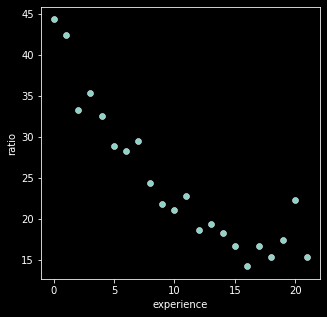

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

fig = plt.figure(figsize=(5,5));
sns.scatterplot(temp.index.astype(int), temp['ratio']);

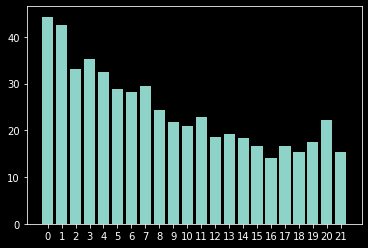

In [ ]:
plt.bar(temp.index.astype(str), temp['ratio']);

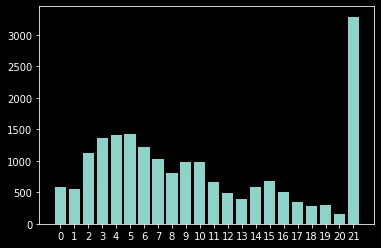

In [ ]:
# ▶ count-histogram
plt.bar(temp.index.astype(str), temp['count']);

### 관련 경험 및 전공 유무에 따라 이직률이 다를 것이다.
---

In [ ]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,None,None,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,None,No relevent experience,Full time course,Graduate,STEM,5,None,None,never,83,0.0
3,33241,city_115,0.789,None,No relevent experience,None,Graduate,Business Degree,0,None,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,50-99,Funded Startup,4,8,0.0


In [ ]:
df['relevent_experience'].value_counts()

Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64

In [ ]:
temp = df.groupby('relevent_experience')['target'].agg(['count', 'sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100,2)
temp

# 관련경력이 없을 수록 이직확률이 큼

,count,sum,ratio
relevent_experience,,,
Has relevent experience,13792,2961.0,21.47
No relevent experience,5366,1816.0,33.84


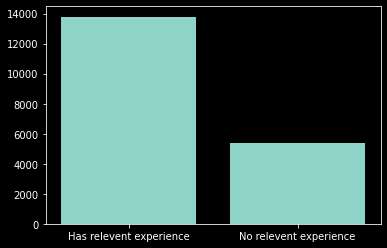

In [ ]:
plt.bar(temp.index.astype(str), temp['count']);

In [ ]:
df['enrolled_university'].value_counts()

no_enrollment       13817
Full time course     3757
Part time course     1198
None                  386
Name: enrolled_university, dtype: int64

In [ ]:

temp = df.groupby('enrolled_university')['target'].agg(['count', 'sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100,2)
temp

# 고학력 대학 과정의 종류일 수록 이직률이 높음

,count,sum,ratio
enrolled_university,,,
Full time course,3757,1431.0,38.09
None,386,123.0,31.87
Part time course,1198,302.0,25.21
no_enrollment,13817,2921.0,21.14


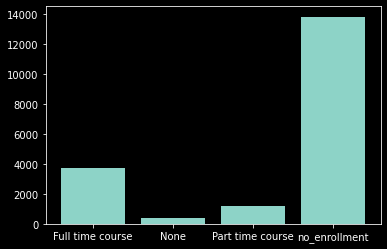

In [ ]:
plt.bar(temp.index.astype(str), temp['count']);

In [ ]:
df['education_level'].value_counts()

Graduate          11598
Masters            4361
High School        2017
None                460
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [ ]:
temp = df.groupby('education_level')['target'].agg(['count', 'sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100,2)
temp.sort_values(by=['ratio'], ascending=False)

# 교육수준(education_level)이 올라갈수록 이직률이 낮아짐

,count,sum,ratio
education_level,,,
Graduate,11598,3245.0,27.98
None,460,104.0,22.61
Masters,4361,935.0,21.44
High School,2017,394.0,19.53
Phd,414,58.0,14.01
Primary School,308,41.0,13.31


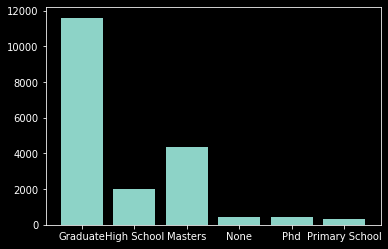

In [ ]:
plt.bar(temp.index.astype(str), temp['count']);

In [ ]:
df['major_discipline'].value_counts()

STEM               14492
None                2813
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [ ]:
temp = df.groupby('major_discipline')['target'].agg(['count', 'sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100,2)
temp

# 전공(major_discipline)에 따른 이직률은 큰 차이는 없음

,count,sum,ratio
major_discipline,,,
Arts,253,53.0,20.95
Business Degree,327,86.0,26.30
Humanities,669,141.0,21.08
No Major,223,55.0,24.66
None,2813,549.0,19.52
Other,381,102.0,26.77
STEM,14492,3791.0,26.16


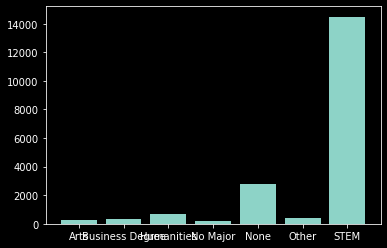

In [ ]:
plt.bar(temp.index.astype(str), temp['count']);

## **Session 3**  
**┗ TabNet 활용 이직 예측**  
---

### 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [ ]:
# Validation 활용 이유 : Hyperparamter 튜닝을 위한 중간 검증 Set, Test set을 온전히 평가 하기 위함
import numpy as np

target = 'target'
if "Set" not in df.columns:
    df["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(df.shape[0],))

train_indices = df[df['Set']=="train"].index
valid_indices = df[df['Set']=="valid"].index
test_indices = df[df['Set']=="test"].index

df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,Set
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,None,None,1,36,1.0,test
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,train
2,11561,city_21,0.624,None,No relevent experience,Full time course,Graduate,STEM,5,None,None,never,83,0.0,train
3,33241,city_115,0.789,None,No relevent experience,None,Graduate,Business Degree,0,None,Pvt Ltd,never,52,1.0,train
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,50-99,Funded Startup,4,8,0.0,train


In [ ]:
len(train_indices), len(valid_indices), len(test_indices)

(15386, 1879, 1893)

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = []
categorical_dims =  {}
for col in df.columns[df.dtypes == object]:
    print(col, df[col].nunique())
    l_enc = LabelEncoder()
    df[col] = l_enc.fit_transform(df[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

city 123
gender 4
relevent_experience 2
enrolled_university 4
education_level 6
major_discipline 7
company_size 9
company_type 7
last_new_job 7
Set 3


In [ ]:
print(categorical_columns)

['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type', 'last_new_job', 'Set']


In [ ]:
categorical_dims

{'city': 123,
 'gender': 4,
 'relevent_experience': 2,
 'enrolled_university': 4,
 'education_level': 6,
 'major_discipline': 7,
 'company_size': 9,
 'company_type': 7,
 'last_new_job': 7,
 'Set': 3}

In [ ]:
# TabNet을 활용하기 위해서는 카테고리 변수와 dim을 전달해야 함
unused_feat = ['Set', 'enrollee_id']
features = [ col for col in df.columns if col not in unused_feat+[target]]
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

### 모델 학습 및 평가
---
* 딥러닝 모델 학습 및 평가

In [ ]:
X_train = df[features].values[train_indices]
y_train = df[target].values[train_indices]

X_valid = df[features].values[valid_indices]
y_valid = df[target].values[valid_indices]

X_test = df[features].values[test_indices]
y_test = df[target].values[test_indices]

In [ ]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# optimizer: 이전에 정의한 optimizer 변수명을 넣어준다.
# step_size: 몇 epoch마다 lr을 감소시킬지가 step_size를 의미한다.
# gamma: gamma 비율로 lr을 감소시킨다.

clf = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=10,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    # scheduler_params = {"gamma": 0.95,
                    #  "step_size": 20},
    # scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

In [ ]:
# patience = Number of consecutive epochs without improvement before performing early stopping

max_epochs = 50
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss'],
    max_epochs=max_epochs, patience=100,
    batch_size=1024, virtual_batch_size=128)

epoch 0  | loss: 0.64755 | train_logloss: 0.5716  | valid_logloss: 0.57322 |  0:00:02s
epoch 1  | loss: 0.52973 | train_logloss: 0.58672 | valid_logloss: 0.59093 |  0:00:04s
epoch 2  | loss: 0.49929 | train_logloss: 0.57678 | valid_logloss: 0.58345 |  0:00:06s
epoch 3  | loss: 0.48924 | train_logloss: 0.55654 | valid_logloss: 0.5721  |  0:00:07s
epoch 4  | loss: 0.47714 | train_logloss: 0.55743 | valid_logloss: 0.55586 |  0:00:09s
epoch 5  | loss: 0.47303 | train_logloss: 0.55153 | valid_logloss: 0.55567 |  0:00:11s
epoch 6  | loss: 0.47562 | train_logloss: 0.56261 | valid_logloss: 0.57106 |  0:00:13s
epoch 7  | loss: 0.46588 | train_logloss: 0.54035 | valid_logloss: 0.54496 |  0:00:15s
epoch 8  | loss: 0.46074 | train_logloss: 0.54164 | valid_logloss: 0.54887 |  0:00:16s
epoch 9  | loss: 0.45597 | train_logloss: 0.54429 | valid_logloss: 0.55826 |  0:00:18s
epoch 10 | loss: 0.45508 | train_logloss: 0.54038 | valid_logloss: 0.54825 |  0:00:20s
epoch 11 | loss: 0.45239 | train_logloss: 0

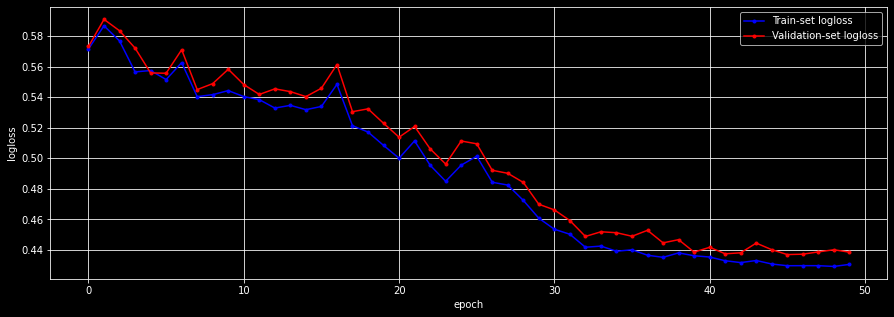

In [ ]:
import numpy as np
train_logloss = clf.history['train_logloss']
val_logloss = clf.history['valid_logloss']


x_len = np.arange(len(val_logloss))
plt.figure(figsize=(15, 5))
plt.plot(x_len, train_logloss, marker='.', c='blue', label="Train-set logloss")
plt.plot(x_len, val_logloss, marker='.', c='red', label="Validation-set logloss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('logloss')
plt.show()

In [ ]:
preds = clf.predict_proba(X_test)
proba = preds[:,1]
print(proba[0:5])

[0.62935287 0.07734535 0.68199885 0.07390862 0.09281984]


In [ ]:
y_pred = clf.predict(X_test)
print(y_pred[0:5])

[1. 0. 1. 0. 0.]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85      1394
         1.0       0.58      0.56      0.57       499

    accuracy                           0.78      1893
   macro avg       0.71      0.71      0.71      1893
weighted avg       0.78      0.78      0.78      1893



In [ ]:
from sklearn.metrics import roc_auc_score

roc_score_test = roc_auc_score(y_test, preds[:,1])
print("roc_score_test :", roc_score_test)

roc_score_test : 0.7790228951446653


In [ ]:
from sklearn.metrics import roc_curve
def roc_curve_plot(y_test , pred_proba_c1):
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    plt.plot(fprs , tprs, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--', label='Random', color='red')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

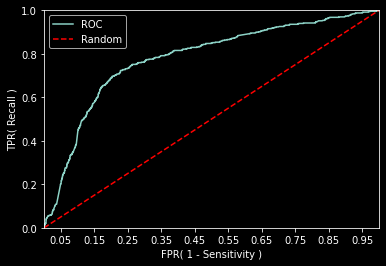

In [ ]:
roc_curve_plot(y_test, preds[:,1])

### 변수 중요도 분석(Global, Local)
---
* TabNet의 장점 : 개별 Instance에 대한 Local 중요도와, 전체 관점에서 Global 중요도를 확인 가능

In [ ]:
features

['city',
 'city_development_index',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'training_hours']

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 12 Text major ticklabel objects>)

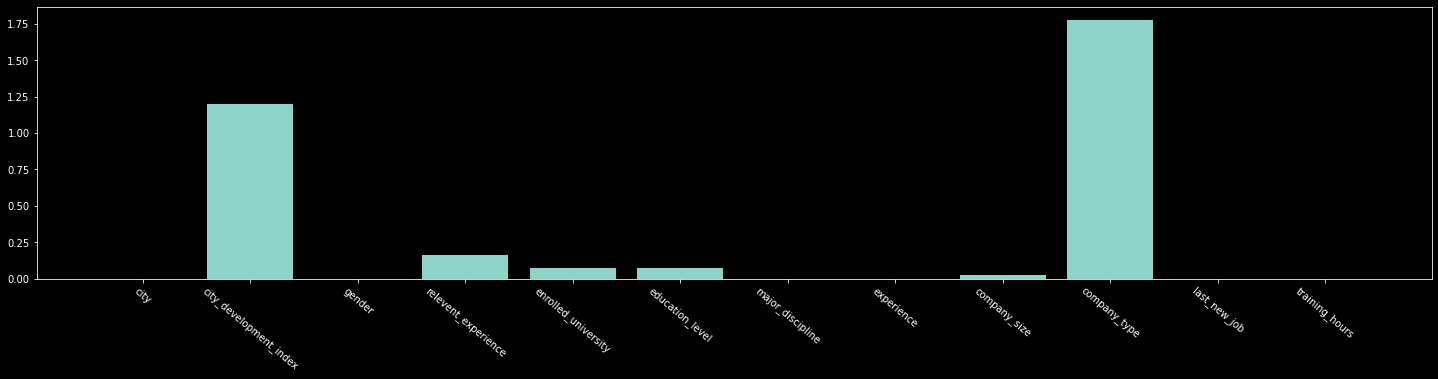

In [ ]:
# - 영향을 끼친 변수는 0으로 출력
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])

explain_matrix, masks = clf.explain(X_test)

fig = plt.figure(figsize=(25,5));
plt.bar(features, explain_matrix[3]);
plt.xticks(features);
plt.xticks(rotation=-40)

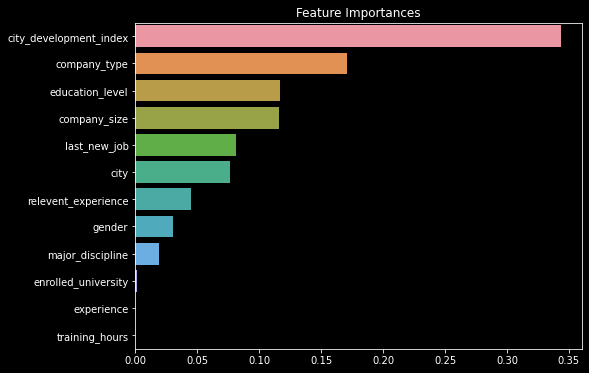

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = features)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [ ]:
temp = df.groupby('city_development_index')['target'].agg(['count', 'sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100,2)
temp

,count,sum,ratio
city_development_index,,,
0.448,17,11.0,64.71
0.479,28,15.0,53.57
0.487,5,4.0,80.00
0.493,13,7.0,53.85
0.512,5,3.0,60.00
0.516,12,7.0,58.33
0.518,6,4.0,66.67
0.527,92,52.0,56.52
0.550,247,147.0,59.51


In [ ]:
temp = df.groupby('company_type')['target'].agg(['count', 'sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100,2)
temp

,count,sum,ratio
company_type,,,
Early Stage Startup,603,142.0,23.55
Funded Startup,1001,140.0,13.99
NGO,521,97.0,18.62
None,6140,2384.0,38.83
Other,121,29.0,23.97
Public Sector,955,210.0,21.99
Pvt Ltd,9817,1775.0,18.08


In [ ]:
temp = df.groupby('company_size')['target'].agg(['count', 'sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100,2)
temp

,count,sum,ratio
company_size,,,
10/49,1471,344.0,23.39
100-500,2571,415.0,16.14
1000-4999,1328,200.0,15.06
10000+,2019,385.0,19.07
50-99,3083,545.0,17.68
500-999,877,152.0,17.33
5000-9999,563,102.0,18.12
<10,1308,224.0,17.13
None,5938,2410.0,40.59
